In [13]:
%load_ext autoreload
%autoreload 2

from math import ceil

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

from plot_shift.cost_threshold_plot import binary_classifier_curve, cost_threshold_plot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Load the MNIST dataset
mnist = fetch_openml('mnist_784', as_frame=False)

In [3]:
# Split the dataset into training and testing sets
X, y = mnist.data, mnist.target.astype(int)

In [4]:
# Convert the target variable to binary (0 or 1) for the digit '5'
y_binary = (y == 5).astype(int)

In [5]:
# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [12]:
random_state = 42

k_fold = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)
models = [
    ["Logistic Regression", LogisticRegression(random_state=random_state)],
    ["Random Forest Classifier", RandomForestClassifier(random_state=random_state)],
]
model_scores = []

for name, model in models:
    # Initialize an array to hold the scores for each fold
    scores = np.zeros(len(y))

    for train_index, test_index in k_fold.split(X_scaled, y_binary):
        # Split the data into training and testing sets
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train = y_binary[train_index]
        # Fit the model and predict probabilities
        model.fit(X_train, y_train)
        scores[test_index] = model.predict_proba(X_test)[:, 1]

    # Collect model name and scores
    model_scores.append((name, scores))

In [8]:
# Define costs for false positives and false negatives
C_FP = 1  # Cost of false positive
C_FN = 5  # Cost of false negative

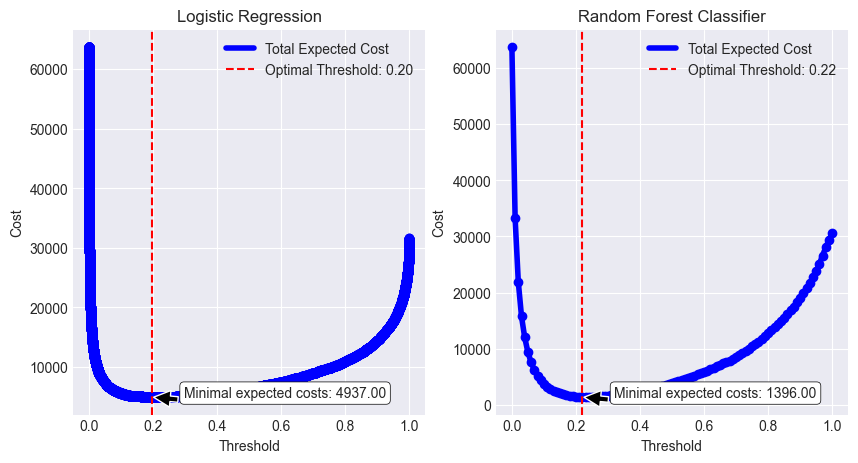

In [32]:

plt.style.use("seaborn-v0_8-darkgrid")

rows = ceil(len(model_scores) / 2)
_, axes = plt.subplots(rows, 2, figsize=(10, rows * 5))

for ax, (name, scores) in zip(axes.flatten(), model_scores):
    true_positives, false_positives, false_negatives, thresholds = (
        binary_classifier_curve(y_binary, scores)
    )
    total_costs = C_FP * false_positives + C_FN * false_negatives

    cost_threshold_plot(
        total_costs,
        thresholds,
        ax=ax,
        model_name=name,
    )